# Black Friday Sales Prediction

This dataset comprises of sales transactions captured at a retail store. It’s a classic dataset to expand features and understand from multiple shopping experiences. This is a regression problem. The dataset has 550,069 rows and 12 columns.

**Problem:** Predict purchase amount.

## Libraries

In [2]:
# python 3 environment
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

# plotly Libraris
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

# catboost for regression
from lightgbm import LGBMRegressor
from sklearn.metrics import precision_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Step 1: Data

In [3]:
data = pd.read_csv('../Black Friday Sales Prediction/Data Sources/train.csv'); data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [ ]:
data.head(3)

## Step 2: Exploratory Data Analysis 

Before creating a prediction model, the understanding of the data will be done by visually schematizing the answer to multiple questions of curiosity and understanding the context of the data.

How does gender influence spending?

How does marital status affect price? 

How many unique users are there in the database?

How does gender influence spending?

What is the best selling category? 


### How many unique users are there in the database? 

In [ ]:
print(f'The data consists of {data.shape[0]} rows with {data.User_ID.nunique()} unique users')

### How does gender influence spending?

### How does marital status affect price?  

## Step 3: Model

### 3.1 Preprocessing Data

Downgrading data type in order to save -85% memory size - 50.4+ MB to 7.5 MB 

In [6]:
# downgrading
data.User_ID = data.User_ID.apply(lambda x: x - 1000000).astype('uint8')
data.Product_ID = data.Product_ID.apply(lambda x: x.replace('P', '0')).astype('uint32')
data.Gender = data.Gender.astype('category')
data.Age = data.Age.apply(lambda x: x.replace('+', '-55'))
data.Age = data.Age.apply(lambda x: x.split('-')[0]).astype('uint8')
data.Occupation = data.Occupation.astype('category')
data.City_Category = data.City_Category.astype('category')
data.Stay_In_Current_City_Years = data.Stay_In_Current_City_Years.apply(lambda x: x.split('+')[0]).astype('uint8')
data.Marital_Status = data.Marital_Status.astype('category')
data.Product_Category_1 = data.Product_Category_1.astype('category')
data.Product_Category_2 = data.Product_Category_2.astype('category')
data.Product_Category_3 = data.Product_Category_3.astype('category')
data.Purchase = data.Purchase.astype('uint16')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     550068 non-null  uint8   
 1   Product_ID                  550068 non-null  uint32  
 2   Gender                      550068 non-null  category
 3   Age                         550068 non-null  uint8   
 4   Occupation                  550068 non-null  category
 5   City_Category               550068 non-null  category
 6   Stay_In_Current_City_Years  550068 non-null  uint8   
 7   Marital_Status              550068 non-null  category
 8   Product_Category_1          550068 non-null  category
 9   Product_Category_2          376430 non-null  category
 10  Product_Category_3          166821 non-null  category
 11  Purchase                    550068 non-null  uint16  
dtypes: category(7), uint16(1), uint32(1), uint8(3)
memory usag

In [8]:
data_ohe = pd.get_dummies(data); data_ohe.shape

(550068, 85)

### 3.2 LightGBM

LightGBM, short for Light Gradient Boosted Machine, is a library developed at Microsoft that provides an efficient implementation of the gradient boosting algorithm.

The primary benefit of the LightGBM is the changes to the training algorithm that make the process dramatically faster, and in many cases, result in a more effective model.

The example below first evaluates an LGBMRegressor on the test problem using repeated k-fold cross-validation and reports the mean absolute error. Then a single model is fit on all available data.

In [9]:
# features
X = data_ohe.drop('Purchase', axis=1)

# target variable
y = data_ohe.Purchase

# split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=707)

In [10]:
# evaluate the model
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise', verbose=2)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


MAE: -2078.156 (6.658)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.3s finished


In [12]:
# fit the model on the whole dataset
model = LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

### 3.3 Model Evaluation 

In [13]:
predictions = model.predict(X_test)

# Mean Absolute Error (MAE)
print('MAE: {}'.format(mean_absolute_error(y_test, predictions)))
# Mean Squarred Error (MSE)
print('MSE: {}'.format(mean_squared_error(y_test, predictions)))
# Root Mean Squarred Error (RMSE)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, predictions))))

MAE: 2080.86497040348
MSE: 7633183.150215498
RMSE: 2762.8215921799037


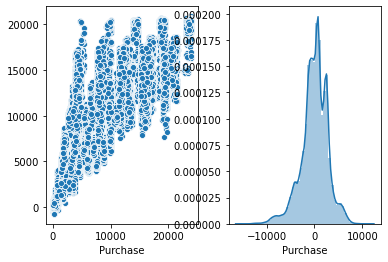

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(ncols=2)
sns.scatterplot(y_test, predictions, ax=axes[0])
sns.distplot((y_test-predictions), ax=axes[1])

plt.show()